In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle
import math
import random
from numba import cuda
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from torchmetrics.text.bert import BERTScore
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from torchmetrics.text.rouge import ROUGEScore
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Preprocessing, load tokenizers, set seed, initialize parameters

In [2]:
device = cuda.get_current_device()
device.reset()

print(torch.cuda.is_available())
torch.cuda.empty_cache()

seed = 42
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = False
torch.manual_seed(seed)
tf.random.set_seed(seed)

np.random.seed(seed)
random.seed(seed)

True


In [2]:
data_matrix = np.load("data/sequences.npy")
print(data_matrix.shape)

lyrics = data_matrix[:, :, 0]
notes = data_matrix[:, :, 1]
durations = data_matrix[:, :, 2]
rests = data_matrix[:, :, 3]

print(lyrics.shape, notes.shape, durations.shape, rests.shape)

(1867, 202, 4)
(1867, 202) (1867, 202) (1867, 202) (1867, 202)


In [3]:
def load_tokenizer(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
        tokenizer = data['tokenizer']
    return tokenizer

In [4]:
tokenizer_lyr = load_tokenizer("tokenizers/tokenizer_lyr.pkl")
tokenizer_note = load_tokenizer("tokenizers/tokenizer_note.pkl")
tokenizer_duration = load_tokenizer("tokenizers/tokenizer_duration.pkl")
tokenizer_rest = load_tokenizer("tokenizers/tokenizer_rest.pkl")

In [6]:
num_songs = len(lyrics)
num_samples = 1600
train_inds = np.random.choice(np.arange(num_songs), size=num_samples, replace=False)
test_inds = np.delete(np.arange(num_songs), train_inds)

train_lyrics = [lyrics[i] for i in train_inds]
test_lyrics = [lyrics[i] for i in test_inds]

train_notes = [notes[i] for i in train_inds]
test_notes = [notes[i] for i in test_inds]

train_durations = [durations[i] for i in train_inds]
test_durations = [durations[i] for i in test_inds]

train_rests = [rests[i] for i in train_inds]
test_rests = [rests[i] for i in test_inds]

# General params
vocab_size = min(len(tokenizer_lyr.word_index) + 1, 10000)
notes_size = len(tokenizer_note.word_index) + 1
durations_size = len(tokenizer_duration.word_index) + 1
rests_size = len(tokenizer_rest.word_index) + 1

pad_id_lyr = tokenizer_lyr.word_index["eos"]
start_id_lyr = tokenizer_lyr.word_index["bos"]

pad_id_note = tokenizer_note.word_index["eos"]
start_id_note = tokenizer_note.word_index["bos"]

pad_id_duration = tokenizer_duration.word_index["eos"]
start_id_duration = tokenizer_duration.word_index["bos"]

pad_id_rest = tokenizer_rest.word_index["eos"]
start_id_rest = tokenizer_rest.word_index["bos"]

max_seq_len = lyrics.shape[1]
batch_size = 32

chencherry = SmoothingFunction()

# Generator params
g_dropout = 0.3
g_embed_dim = 32
g_hidden = 32
pretrain_epochs_gen = 150
g_lr_pretrain = 0.01
g_lr_adv = 1e-4

# Discriminator params
d_embed_dim = 64
d_filter_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
d_num_filters = [100, 200, 200, 200, 200, 100, 100, 100, 100, 100, 160, 160]
d_dropout_prob = 0.2
d_lr = 1e-4


rollout_num = 16
clip_norm = 5.0

adversarial_epochs = 150

In [7]:
max_seq_len 

202

## Model initialization and training

In [8]:
def truncated_normal_(tensor, mean=0, std=1):
    """
    Implemented by @ruotianluo
    See https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/15
    """
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)
    return tensor

In [9]:
class LSTMGenerator(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, note_size,
                 duration_size, rest_size, max_seq_len, pad_id_lyr,
                 pad_id_note, pad_id_dur, pad_id_rest, gpu=False):
        super(LSTMGenerator, self).__init__()
        self.name = 'vanilla'

        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.note_size = vocab_size
        self.duration_size = vocab_size
        self.rest_size = vocab_size
        self.pad_id_lyr = pad_id_lyr
        self.pad_id_note = pad_id_note
        self.pad_id_dur = pad_id_dur
        self.pad_id_rest = pad_id_rest
        self.gpu = gpu

        self.embeddings_lyr = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_id_lyr)
        self.embeddings_note = nn.Embedding(note_size, embedding_dim, padding_idx=pad_id_note)
        self.embeddings_dur = nn.Embedding(duration_size, embedding_dim, padding_idx=pad_id_dur)
        self.embeddings_rest = nn.Embedding(rest_size, embedding_dim, padding_idx=pad_id_rest)
        self.lstm = nn.LSTM(embedding_dim*4, hidden_dim, batch_first=True)
        self.lstm2out = nn.Linear(hidden_dim, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

        self.init_params()

    def forward(self, inp, mel, hidden, need_hidden=False):
        """
        Embeds input and applies LSTM
        :param inp: batch_size * seq_len
        :param hidden: (h, c)
        :param need_hidden: if return hidden, use for sampling
        """
        if len(mel.shape) == 2:
            notes = mel[:, 0]
            durations = mel[:, 1]
            rests = mel[:, 2]
        else:
            notes = mel[:, :, 0]
            durations = mel[:, :, 1]
            rests = mel[:, :, 2]

        emb_lyr = self.embeddings_lyr(inp)  # batch_size * len * embedding_dim
        emb_note = self.embeddings_note(notes)
        emb_dur = self.embeddings_dur(durations)
        emb_rest = self.embeddings_rest(rests)
        
        if len(inp.size()) == 1:
            emb_lyr = emb_lyr.unsqueeze(1)  # batch_size * 1 * embedding_dim
            emb_note = emb_note.unsqueeze(1)
            emb_dur = emb_dur.unsqueeze(1)
            emb_rest = emb_rest.unsqueeze(1)
            
        emb = torch.cat([emb_lyr, emb_note, emb_dur, emb_rest], dim=2)

        out, hidden = self.lstm(emb, hidden)  # out: batch_size * seq_len * hidden_dim
        out = out.contiguous().view(-1, self.hidden_dim)  # out: (batch_size * len) * hidden_dim
        out = self.lstm2out(out)  # (batch_size * seq_len) * vocab_size
        pred = self.softmax(out)

        if need_hidden:
            return pred, hidden
        else:
            return pred

    def sample(self, melody, num_samples, batch_size, start_letter=1): #sample lyrics genorator
        """
        Samples the network and returns num_samples samples of length max_seq_len.
        :return samples: num_samples * max_seq_length (a sampled sequence in each row)
        """
        num_batch = num_samples // batch_size if num_samples != batch_size else 1
        samples = torch.zeros(num_batch * batch_size, self.max_seq_len).long()

        # Generate sentences with multinomial sampling strategy
        for b in range(num_batch):
            hidden = self.init_hidden(batch_size)
            inp = torch.LongTensor([start_letter] * batch_size)
            mel_batch = melody[b * batch_size:(b+1) * batch_size, :]
            if self.gpu:
                inp = inp.cuda()
                mel_batch = mel_batch.cuda()

            for i in range(self.max_seq_len):
                y = mel_batch[:, i, :]
                out, hidden = self.forward(inp, y, hidden, need_hidden=True)  # out: batch_size * vocab_size
                next_token = torch.multinomial(torch.exp(out), 1)  # batch_size * 1 (sampling from each row)
                samples[b * batch_size:(b + 1) * batch_size, i] = next_token.view(-1)
                inp = next_token.view(-1)
        samples = samples[:num_samples]

        return samples

    def init_params(self):
        for param in self.parameters():
            if param.requires_grad and len(param.shape) > 0:
                stddev = 1 / math.sqrt(param.shape[0])
                truncated_normal_(param, std=stddev)

    def init_hidden(self, batch_size=32):
        h = torch.zeros(1, batch_size, self.hidden_dim)
        c = torch.zeros(1, batch_size, self.hidden_dim)

        if self.gpu:
            return h.cuda(), c.cuda()
        else:
            return h, c

In [10]:
class SeqGAN_G(LSTMGenerator):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, note_size,
                 duration_size, rest_size, max_seq_len, pad_id_lyr,
                 pad_id_note, pad_id_dur, pad_id_rest, gpu=False):
        super(SeqGAN_G, self).__init__(embedding_dim, hidden_dim, vocab_size, note_size,
                                       duration_size, rest_size, max_seq_len, pad_id_lyr,
                                       pad_id_note, pad_id_dur, pad_id_rest, gpu)
        self.name = 'seqgan'

    def batchPGLoss(self, inp, mel, target, reward):
        """
        Returns a policy gradient loss
        :param inp: batch_size x seq_len, inp should be target with <s> (start letter) prepended
        :param target: batch_size x seq_len
        :param reward: batch_size (discriminator reward for each sentence, applied to each token of the corresponding sentence)
        :return loss: policy loss
        """

        batch_size, seq_len = inp.size()
        hidden = self.init_hidden(batch_size)

        out = self.forward(inp, mel, hidden).view(batch_size, self.max_seq_len, self.vocab_size)
        target_onehot = F.one_hot(target, self.vocab_size).float()  # batch_size * seq_len * vocab_size
        pred = torch.sum(out * target_onehot, dim=-1)  # batch_size * seq_len
        loss = -torch.sum(pred * reward)

        return loss

In [11]:
class CNNDiscriminator(nn.Module):
    def __init__(self, embed_dim, vocab_size, filter_sizes, num_filters, padding_idx, gpu=False,
                 dropout=0.2):
        super(CNNDiscriminator, self).__init__()
        self.embedding_dim = embed_dim
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.feature_dim = sum(num_filters)
        self.gpu = gpu

        self.embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, n, (f, embed_dim)) for (n, f) in zip(num_filters, filter_sizes)
        ])
        self.highway = nn.Linear(self.feature_dim, self.feature_dim)
        self.feature2out = nn.Linear(self.feature_dim, 2)
        self.dropout = nn.Dropout(dropout)

        self.init_params()

    def forward(self, inp):
        """
        Get final predictions of discriminator
        :param inp: batch_size * seq_len
        :return: pred: batch_size * 2
        """
        feature = self.get_feature(inp)
        pred = self.feature2out(self.dropout(feature))

        return pred

    def get_feature(self, inp):
        """
        Get feature vector of given sentences
        :param inp: batch_size * max_seq_len
        :return: batch_size * feature_dim
        """
        emb = self.embeddings(inp).unsqueeze(1)  # batch_size * 1 * max_seq_len * embed_dim
        convs = [F.relu(conv(emb)).squeeze(3) for conv in self.convs]  # [batch_size * num_filter * length]
        pools = [F.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in convs]  # [batch_size * num_filter]
        pred = torch.cat(pools, 1)  # tensor: batch_size * feature_dim
        highway = self.highway(pred)
        pred = torch.sigmoid(highway) * F.relu(highway) + (1. - torch.sigmoid(highway)) * pred  # highway

        return pred

    def init_params(self):
        for param in self.parameters():
            if param.requires_grad and len(param.shape) > 0:
                stddev = 1 / math.sqrt(param.shape[0])
                truncated_normal_(param, std=stddev)

In [12]:
class SeqGAN_D(CNNDiscriminator):
    def __init__(self, embed_dim, vocab_size, padding_idx, dis_filter_sizes,
                 dis_num_filters, gpu=False, dropout=0.25):
        super(SeqGAN_D, self).__init__(embed_dim, vocab_size, dis_filter_sizes,
                                       dis_num_filters, padding_idx, gpu, dropout)

In [13]:
class GANDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [14]:
class GenDataIter:
    def __init__(self, samples, melodies, batch_size, max_seq_len, start_letter=1, shuffle=True):
        self.batch_size = batch_size
        self.max_seq_len = max_seq_len
        self.start_letter = start_letter

        self.loader = DataLoader(
            dataset=GANDataset(self.__read_data__(samples, melodies)),
            batch_size=self.batch_size,
            shuffle=shuffle,
            drop_last=True)

        self.input = self._all_data_('lyric')
        self.melody = self._all_data_('melody')
        self.target = self._all_data_('target')

    def __read_data__(self, samples, melodies):
        """
        input: same as target, but start with start_letter.
        """
        # global all_data
        inp, target = self.prepare(samples, melodies, self.start_letter)
        lyr, mel = inp
        all_data = [{'lyric': l, 'melody': m, 'target': t} for (l, m, t) in zip(lyr, mel, target)]
        return all_data

    def random_batch(self):
        """Randomly choose a batch from loader, please note that the data should not be shuffled."""
        idx = random.randint(0, len(self.loader) - 1)
        return list(self.loader)[idx]

    def _all_data_(self, col):
        return torch.cat([data[col].unsqueeze(0) for data in self.loader.dataset.data], 0)

    @staticmethod
    def prepare(samples, melodies, start_id, gpu=False):
        """Add start_letter to samples as inp, target same as samples"""
        inp = torch.zeros(samples.size()).long()
        target = samples
        inp[:, 0] = start_id
        inp[:, 1:] = target[:, :max_seq_len - 1]

        if gpu:
            return (inp.cuda(), melodies.cuda()), target.cuda()
        return (inp, melodies), target

In [15]:
def optimize(opt, loss, model=None, retain_graph=False):
    opt.zero_grad()
    loss.backward(retain_graph=retain_graph)
    if model is not None:
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
    opt.step()

In [16]:
def train_gen_epoch(model, data_loader, criterion, optimizer, cuda=True):
    total_loss = 0
    for data in data_loader:
        lyr, mel, target = data['lyric'], data['melody'], data['target']
        if cuda:
            lyr, mel, target = lyr.cuda(), mel.cuda(), target.cuda()

        hidden = model.init_hidden(data_loader.batch_size)
        pred = model.forward(lyr, mel, hidden)
        loss = criterion(pred, target.view(-1))
        optimize(optimizer, loss, model)
        total_loss += loss.item()
    return total_loss / len(data_loader)

## Pretraining

In [17]:
def pretrain_generator(gen, gen_opt, data_loader, criterion, epochs):
    """
    Max Likelihood Pre-training for the generator
    """
    losses = []
    progress = tqdm(range(epochs))
    for epoch in progress:
        pre_loss = train_gen_epoch(gen, data_loader, criterion, gen_opt)
        losses.append(pre_loss)
        progress.set_description("EPOCH: {}, LOSS: {}".format(epoch, pre_loss))
    return losses, gen

In [18]:
sequences_lyrics_train = torch.LongTensor(train_lyrics)
sequences_notes_train = torch.LongTensor(train_notes)
sequences_durations_train = torch.LongTensor(train_durations)
sequences_rests_train = torch.LongTensor(train_rests)

sequences_notes_train = sequences_notes_train.unsqueeze(2)
sequences_durations_train = sequences_durations_train.unsqueeze(2)
sequences_rests_train = sequences_rests_train.unsqueeze(2)

train_melodies = torch.cat([sequences_notes_train, sequences_durations_train, sequences_rests_train], dim=2)

gen_data_iter = GenDataIter(sequences_lyrics_train, train_melodies, batch_size, max_seq_len, start_letter=start_id_lyr)

train_melodies.shape, sequences_lyrics_train.shape

(torch.Size([1600, 202, 3]), torch.Size([1600, 202]))

In [20]:
gen = SeqGAN_G(g_embed_dim, g_hidden, vocab_size, notes_size, durations_size, rests_size,
               max_seq_len, pad_id_lyr, pad_id_note, pad_id_duration, pad_id_rest, True).cuda()

gen_opt = optim.Adam(gen.parameters(), lr=g_lr_pretrain)
gen_adv_opt = optim.Adam(gen.parameters(), lr=g_lr_adv)
mle_criterion = nn.NLLLoss().cuda()

In [64]:
mle_criterion

NLLLoss()

In [21]:
losses_pretrain, model = pretrain_generator(gen, gen_opt, gen_data_iter.loader, mle_criterion, pretrain_epochs_gen)

EPOCH: 149, LOSS: 3.4813875436782835: 100%|██████████| 150/150 [02:34<00:00,  1.03s/it]


In [22]:
model

SeqGAN_G(
  (embeddings_lyr): Embedding(10000, 32, padding_idx=23)
  (embeddings_note): Embedding(100, 32, padding_idx=55)
  (embeddings_dur): Embedding(999, 32, padding_idx=20)
  (embeddings_rest): Embedding(3183, 32, padding_idx=33)
  (lstm): LSTM(128, 32, batch_first=True)
  (lstm2out): Linear(in_features=32, out_features=10000, bias=True)
  (softmax): LogSoftmax(dim=-1)
)

In [22]:
torch.save(model,'model_version2.pt')

In [57]:
##################################
g = torch.load('model_version1.pt')
g

SeqGAN_G(
  (embeddings_lyr): Embedding(10000, 32, padding_idx=23)
  (embeddings_note): Embedding(100, 32, padding_idx=55)
  (embeddings_dur): Embedding(999, 32, padding_idx=20)
  (embeddings_rest): Embedding(3183, 32, padding_idx=33)
  (lstm): LSTM(128, 32, batch_first=True)
  (lstm2out): Linear(in_features=32, out_features=10000, bias=True)
  (softmax): LogSoftmax(dim=-1)
)

In [31]:
##################################
for param in g.parameters():
    print(param)

Parameter containing:
tensor([[-5.9218e-03,  1.3934e-02,  7.4154e-03,  ...,  1.0147e-02,
         -1.9841e-04, -3.3769e-03],
        [ 4.9049e-01, -3.3754e-02,  8.1550e-03,  ...,  1.6835e+00,
          6.4918e-02, -5.0949e-01],
        [-1.2724e+00, -8.8861e-01,  1.2629e+00,  ...,  3.2086e+00,
          9.0258e-01,  6.9196e-01],
        ...,
        [ 2.3715e+00,  2.4337e-01, -8.2557e-01,  ..., -9.5137e-01,
         -4.8735e-01, -2.0917e+00],
        [ 2.4809e-02, -1.0312e+00,  2.1266e-01,  ..., -6.2788e-01,
         -8.1744e-01,  2.6475e+00],
        [-4.6585e-01, -1.6732e+00, -1.8177e+00,  ..., -1.0722e+00,
         -1.3848e+00, -8.4122e-01]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.1190,  0.0102,  0.0636,  ..., -0.0101, -0.1760,  0.1473],
        [ 0.1958,  0.5849, -0.6788,  ...,  0.4243,  0.1590,  0.0947],
        [-0.5535,  0.2482, -0.9394,  ...,  0.0989, -0.1428, -0.4852],
        ...,
        [ 0.7463,  3.4836,  0.5530,  ..., -3.4136, -2.0195, -2.0

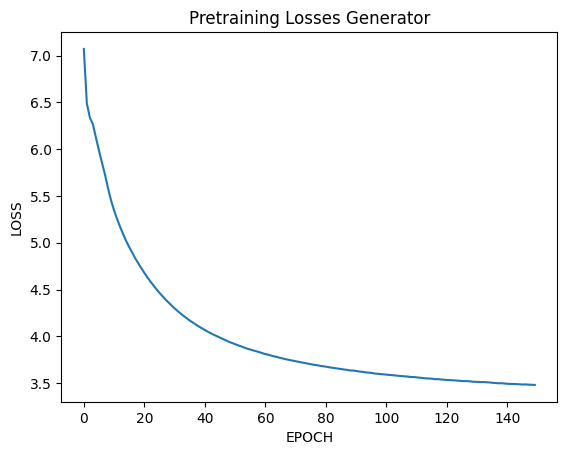

In [23]:
plt.plot(losses_pretrain)
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.title("Pretraining Losses Generator")
plt.savefig("Pretraining Losses SeqGenerator.png")
plt.show()

In [61]:
losses_pretrain[-1]

3.4813875436782835

## Adversarial Training

In [24]:
class ROLLOUT:
    def __init__(self, gen, gpu=True):
        self.gen = gen
        self.old_model = copy.deepcopy(gen)
        self.max_seq_len = gen.max_seq_len
        self.vocab_size = gen.vocab_size
        self.gpu = gpu

    def rollout_mc_search(self, sentences, melodies, given_num):
        """
        fill up remain tokens with MC search
        :param sentences: size of batch_size * max_seq_len
        :param given_num:
        :return:
        """
        batch_size = sentences.size(0)

        # get current state
        hidden = self.gen.init_hidden(batch_size)
        # for i in range(given_num):
        inp = sentences[:, :given_num]
        mel = melodies[:, :given_num, :]
        out, hidden = self.gen.forward(inp, mel, hidden, need_hidden=True)
        out = out.view(batch_size, -1, self.vocab_size)[:, -1]

        samples = torch.zeros(batch_size, self.max_seq_len).long()
        samples[:, :given_num] = sentences[:, :given_num]

        if self.gpu:
            samples = samples.cuda()

        # MC search
        for i in range(given_num, self.max_seq_len):
            out = torch.multinomial(torch.exp(out), 1)
            samples[:, i] = out.view(-1).data
            inp = out.view(-1)
            mel = melodies[:, i, :]
            mel = torch.squeeze(mel, dim=1)

            out, hidden = self.gen.forward(inp, mel, hidden, need_hidden=True)

        return samples

    def get_reward(self, sentences, melodies, rollout_num, dis, current_k=0):
        """
        get reward via Monte Carlo search
        :param sentences: size of batch_size * max_seq_len
        :param rollout_num:
        :param dis:
        :param current_k: current training gen
        :return: reward: [batch_size]
        """
        with torch.no_grad():
            batch_size = sentences.size(0)
            rewards = torch.zeros([rollout_num * self.max_seq_len, batch_size]).float()
            if self.gpu:
                rewards = rewards.cuda()
            idx = 0
            for i in range(rollout_num):
                for given_num in range(1, self.max_seq_len + 1):
                    samples = self.rollout_mc_search(sentences, melodies, given_num)
                    out = dis.forward(samples)
                    out = F.softmax(out, dim=-1)
                    reward = out[:, current_k + 1]
                    rewards[idx] = reward
                    idx += 1

        # rewards = torch.mean(rewards, dim=0)
        rewards = torch.mean(rewards.view(batch_size, self.max_seq_len, rollout_num), dim=-1)
        return rewards

In [25]:
def remove_start_and_end(lyrics):
    clean_lyrics = []
    for lyric in lyrics:
        removal_list = ["BOS","EOS", "eos", "bos"]
        lyric_list = lyric.split()
        final_list = [word for word in lyric_list if word not in removal_list]
        final_string = ' '.join(final_list)
        clean_lyrics.append(final_string)

    return clean_lyrics

In [26]:
class DisDataIter:
    def __init__(self, pos_samples, neg_samples):
        self.batch_size = 16
        self.max_seq_len = 202
        self.start_letter = 0

        self.loader = DataLoader(
            dataset=GANDataset(self.__read_data__(pos_samples, neg_samples)),
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True)

    def __read_data__(self, pos_samples, neg_samples):
        """
        input: same as target, but start with start_letter.
        """
        inp, target = self.prepare(pos_samples, neg_samples)
        all_data = [{'input': i, 'target': t} for (i, t) in zip(inp, target)]
        return all_data

    def random_batch(self):
        idx = random.randint(0, len(self.loader) - 1)
        return list(self.loader)[idx]

    def prepare(self, pos_samples, neg_samples):
        """Build inp and target"""
        inp = torch.cat((pos_samples, neg_samples), dim=0).long().detach()  # !!!need .detach()
        target = torch.ones(inp.size(0)).long()
        target[pos_samples.size(0):] = 0

        # shuffle
        perm = torch.randperm(inp.size(0))
        inp = inp[perm].cuda()
        target = target[perm].cuda()

        return inp, target

In [27]:
dis = SeqGAN_D(d_embed_dim, vocab_size, pad_id_lyr, d_filter_sizes, d_num_filters, gpu=True).cuda()
dis_opt = optim.Adam(dis.parameters(), lr=d_lr)
dis_criterion = nn.CrossEntropyLoss().cuda()

In [28]:
def adv_train_generator(gen, dis, melody, batch_size, rollout_num, gen_adv_opt, start_letter, g_step, cuda=True):
    """
    The gen is trained using policy gradients, using the reward from the discriminator.
    Training is done for num_batches batches.
    """
    rollout_func = ROLLOUT(gen, True)
    total_g_loss = 0
    for step in range(g_step):
        (inp, mel), target = GenDataIter.prepare(gen.sample(melody, batch_size, batch_size, start_letter),
                                                 melody, start_letter, gpu=True)
        if cuda:
            inp = inp.cuda()
            mel = mel.cuda()
            target = target.cuda()

        # ===Train===
        rewards = rollout_func.get_reward(target, mel, rollout_num, dis)
        adv_loss = gen.batchPGLoss(inp, mel, target, rewards)
        optimize(gen_adv_opt, adv_loss)
        total_g_loss += adv_loss.item()
    return total_g_loss

In [29]:
def train_dis_epoch(model, data_loader, criterion, optimizer, CUDA=True):
    total_loss = 0
    total_acc = 0
    total_num = 0
    for i, data in enumerate(data_loader):
        inp, target = data['input'], data['target']
        if CUDA:
            inp, target = inp.cuda(),target.cuda()

        pred = model.forward(inp)
        loss = criterion(pred, target)
        optimize(optimizer, loss, model)

        total_loss += loss.item()
        total_acc += torch.sum((pred.argmax(dim=-1) == target)).item()
        total_num += inp.size(0)

    total_loss /= len(data_loader)
    total_acc /= total_num
    return total_loss, total_acc

In [30]:
def train_discriminator(gen, dis, batch_size, train_data,
                        dis_criterion, dis_opt, d_step, d_epoch):
    """
    Training the discriminator on real_data_samples (positive) and generated samples from gen (negative).
    Samples are drawn d_step times, and the discriminator is trained for d_epoch d_epoch.
    """
    # prepare loader for validate
    global d_loss, train_acc
    losses, accs = [], []
    for step in range(d_step):
        # prepare loader for training
        targets = train_data.target
        inds = np.arange(targets.shape[0])
        rand_inds = np.random.choice(inds, 8 * batch_size)
        pos_samples = gen_data_iter.target[rand_inds]
        neg_samples = gen.sample(gen_data_iter.melody, 8 * batch_size, batch_size)
        dis_data = DisDataIter(pos_samples, neg_samples)
        d_losses, train_accs = [], []
        for epoch in range(d_epoch):
            # ===Train===
            d_loss, train_acc = train_dis_epoch(dis, dis_data.loader, dis_criterion, dis_opt)
            d_losses.append(d_loss)
            train_accs.append(train_acc)

        losses.append(np.mean(d_losses))
        accs.append(np.mean(train_accs))
    return losses, accs

In [31]:
def adversarial_train(gen, dis, gen_adv_opt, dis_adv_opt, train_data, batch_size,
                      dis_criterion, rollout_num, epochs, start_letter=1):
    progress = tqdm(range(epochs))
    g_losses, d_losses, d_accs = [], [], []
    for adv_epoch in progress:
        rand_batch = train_data.random_batch()
        lyric = rand_batch["lyric"]
        melody = rand_batch["melody"]
        target = rand_batch["target"]
        g_loss = adv_train_generator(gen, dis, melody, batch_size, rollout_num, gen_adv_opt, start_letter, 2)
        d_loss, accs = train_discriminator(gen, dis, batch_size, gen_data_iter, dis_criterion, dis_adv_opt, 1, 1)
        g_losses.append(g_loss)
        d_losses.append(np.mean(d_loss))
        d_accs.append(np.mean(accs))
        progress.set_description('g_loss: %.4f, d_loss: %.4f, g_acc: %.4f' % (g_loss, np.mean(d_loss), np.mean(accs)))

    return g_losses, d_losses, d_accs, gen, dis

In [33]:
adversarial_epochs=180

In [34]:
import os
import torch
import torch.nn as nn

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)  # 출력결과: cuda 
print('Count of using GPUs:', torch.cuda.device_count())   #출력결과: 2 (2, 3 두개 사용하므로)
print('Current cuda device:', torch.cuda.current_device())  

Device: cuda
Count of using GPUs: 2
Current cuda device: 0


In [72]:
print('Current cuda device:', torch.cuda.current_device())

Current cuda device: 0


In [26]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [65]:
dis_criterion

CrossEntropyLoss()

In [36]:
g_losses, d_losses, d_accs, genorator, discriminator= adversarial_train(gen,dis, gen_adv_opt, dis_opt,
                                               gen_data_iter, 32, dis_criterion,
                                               rollout_num, adversarial_epochs, start_id_lyr)

g_loss: 11.1555, d_loss: 0.0006, g_acc: 1.0000: 100%|██████████| 180/180 [15:03:16<00:00, 301.09s/it]    


In [37]:
torch.save(genorator,'genorator_version2.pt')
torch.save(discriminator,'discriminator_version2.pt')

In [59]:
d = torch.load('discriminator_version2.pt')
d

SeqGAN_D(
  (embeddings): Embedding(10000, 64, padding_idx=23)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(1, 64), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(2, 64), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(3, 64), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(4, 64), stride=(1, 1))
    (4): Conv2d(1, 200, kernel_size=(5, 64), stride=(1, 1))
    (5): Conv2d(1, 100, kernel_size=(6, 64), stride=(1, 1))
    (6): Conv2d(1, 100, kernel_size=(7, 64), stride=(1, 1))
    (7): Conv2d(1, 100, kernel_size=(8, 64), stride=(1, 1))
    (8): Conv2d(1, 100, kernel_size=(9, 64), stride=(1, 1))
    (9): Conv2d(1, 100, kernel_size=(10, 64), stride=(1, 1))
    (10): Conv2d(1, 160, kernel_size=(15, 64), stride=(1, 1))
    (11): Conv2d(1, 160, kernel_size=(20, 64), stride=(1, 1))
  )
  (highway): Linear(in_features=1720, out_features=1720, bias=True)
  (feature2out): Linear(in_features=1720, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [38]:
g_losses[-1]

11.15551233291626

In [39]:
d_loss

0.0006387298193430979

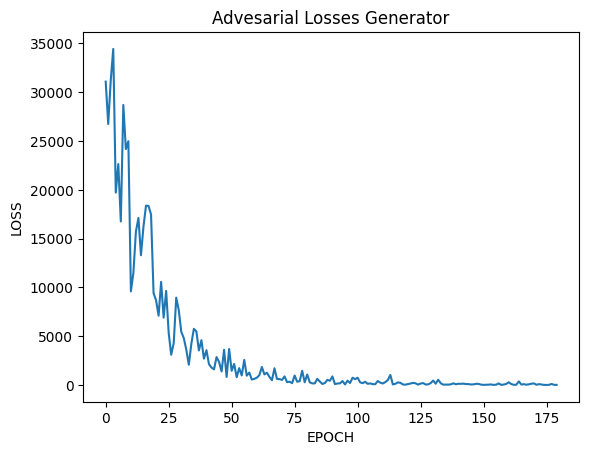

In [40]:
plt.plot(g_losses)
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.title("Advesarial Losses Generator")
plt.savefig("Advesarial Losses SeqGenerator.png")
plt.show()

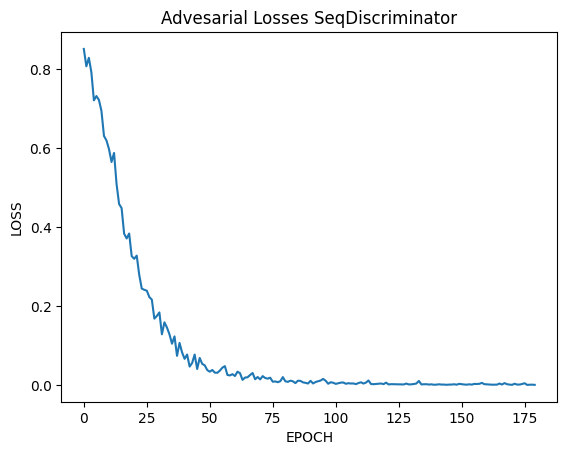

In [41]:
plt.plot(d_losses)
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.title("Advesarial Losses SeqDiscriminator")
plt.savefig("Advesarial Losses SeqDiscriminator.png")
plt.show()

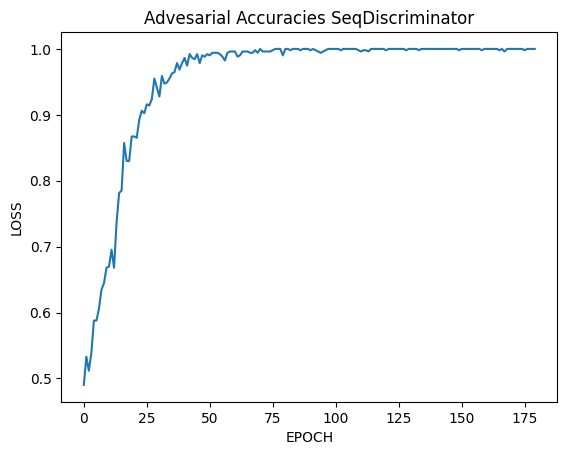

In [42]:
plt.plot(d_accs)
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.title("Advesarial Accuracies SeqDiscriminator")
plt.savefig("Advesarial Accuracies SeqDiscriminator.png")
plt.show()

## Evaluation

In [45]:
test_is = np.random.choice(test_inds, 80)

test_nos = np.expand_dims(np.array([notes[i] for i in test_is]), axis=2)
test_dus = np.expand_dims(np.array([durations[i] for i in test_is]), axis=2)
test_res = np.expand_dims(np.array([rests[i] for i in test_is]), axis=2)
test_lyr = [lyrics[i] for i in test_is]

test_mels = np.concatenate([test_nos, test_dus, test_res], axis=2)
test_mels = torch.LongTensor(test_mels)
test_mels.shape

torch.Size([80, 202, 3])

In [47]:
samples = gen.sample(test_mels, 80, 16, start_id_lyr)
preds = tokenizer_lyr.sequences_to_texts(samples.numpy())
orig = tokenizer_lyr.sequences_to_texts(test_lyr)

preds = remove_start_and_end(preds)
orig = remove_start_and_end(orig)

In [48]:
preds[-1]

'올해 여름 햇살 을 왔냐 슬퍼 닥쳐 닥쳐 닥쳐 닥쳐 원해 말 대로 힘들어 도 뛰고 만들었던 거야 넌 됐어 우린 숨 좋은 그날 위 에 박혀 좀 더 편하다고 생각 하지 oov 너 만 못 잊겠어 왜 이렇게 말 해줘 네 가 oov 당신 은 영웅 날 에 어떤 길 있다면 자꾸 태양 처럼 차라리 나를 위 한 my 푸시 아기 주다 푸시 푸시 아기 소녀 남자 나비 딱이야 하나 일 은 그만 잊어요 오늘 만은 워 또 두 개 올라 또 oov 사는 그 때 해도 좀 더 섹시해 우린 화끈한 사랑 해보고 싶어 캔트 ㅏ 그만큼 예쁜 눈물 안녕 그래 섹시한 배 oov 걸었던 방법 그대로 열 힘든 하루 종일 oov 넘쳐 나 에게 oov 많이 여우 이 아니야 나 는 마법 에 아래 에 잠긴 채 그 댈 사랑 하다 나'

In [49]:
orig[-1]

'또 울 고 oov 이 젠 그만 나를 oov 커다란 그대 사랑 oov 맘 편히 쉴 수 있게 긴 세월 이 흐른 후 그대 좋은 사람 만나서 행복한 모습 볼 수 있도록 나 그 댈 oov 우리 함께 한 많은 날 들 이 너무나 소중해 그래도 웃 을 수 있죠 혼자 인게 oov 땐 그 댈 아프게 한 내 모습 만 떠 울리며 살아요 긴 그대 의 한숨 을 모두 가져갈 수 없다면 차라리 그대 그림자 되어 나 항상 그대 곁 에 우리 함께 한 많은 날 들 이 너무나 소중해 그래도 웃을수 있죠 혼자 인게 oov 땐 그 댈 아프게 한 내 모습 만 기억 해봐요 그대 세상 에 홀로 남겨진 그대 를 잠시 라도 만날 수 있다면 단 하루 라도 oov 가는 그 댈 위해 날 닮은 사람 보내줄께요 그 에게서 날 봐요'

In [50]:
import pandas as pd
df = pd.DataFrame(orig,columns = ['origin'])
df

,origin
0,그녀 갖다 나 다 쓴 미친 왜 심장 이 뛰니 넌 아름다워 나 의 여신 oov 응 응...
1,아 증가 위로 하다 아니다 엉망 주위 에 그만큼 시각 이다 위로 가 따 비명 지금 ...
2,1 2 오다 에 아르 자형 에 준비 가 된 3 4 하다 그것 나 는 준비 가 된 5...
3,사랑 한다는 말 나 하나 란 말 내 가 전 부란 말 기억 못 하면 좋겠어 눈부신 날...
4,해질 무렵 날 끌 oov 발걸음 눈 떠보니 잊은줄 알았던 곳 에 아직도 너 의 대한...
...,...
75,내 가 있는 곳 은 어딜 까 꿈꿔 왔던 바로 거 oov 시간 지날수록 왜 이리 쉽게...
76,헤어지잔 몹쓸 말 죽어도 듣기 싫은 말 끝내 oov 바랬어 눈물 이 흐를 것 만 같...
77,요즘 널 보는 눈빛 oov 않았니 어쩜 그렇게도 무 뎌 정말 oov 숨기 고 싶지 ...
78,자꾸 떠올리면 자꾸 oov 혹시 추억 마저 oov 참아야겠지 아껴 oov 니 가 준...


In [51]:
df1 = pd.DataFrame(preds, columns = ['preds'])

In [52]:
result1 = pd.concat([df,df1],axis=1)
result1

,origin,preds
0,그녀 갖다 나 다 쓴 미친 왜 심장 이 뛰니 넌 아름다워 나 의 여신 oov 응 응...,가고 없어도 내 목소릴 본 적은 달라진것 그냥 은근 뜨 않는 벽 oov 이야 숨 이...
1,아 증가 위로 하다 아니다 엉망 주위 에 그만큼 시각 이다 위로 가 따 비명 지금 ...,넌 내게 너무나도 못 떠나 버린 가슴 널 보면 곧 흉터 손목 랑 명음 랄랄라 랄 랄...
2,1 2 오다 에 아르 자형 에 준비 가 된 3 4 하다 그것 나 는 준비 가 된 5...,뭘 해 줘요 oov 좋은 사람 이 밝아오면 보고 파 가을 언덕 추는 응 반짝이는 척...
3,사랑 한다는 말 나 하나 란 말 내 가 전 부란 말 기억 못 하면 좋겠어 눈부신 날...,마치 감각 은 모른 채 우리 둘 만큼 정신 돼 그때 니 가 떠난 그런 그녀 품 에 ...
4,해질 무렵 날 끌 oov 발걸음 눈 떠보니 잊은줄 알았던 곳 에 아직도 너 의 대한...,싶었어 차마 갔나요 그 댈 oov 아무리 싫어도 널 데려가는 건 사랑 이 아픈 건지...
...,...,...
75,내 가 있는 곳 은 어딜 까 꿈꿔 왔던 바로 거 oov 시간 지날수록 왜 이리 쉽게...,회사 골목 은 하고싶은데 나 처럼 누구 한 너 의 맘 oov oov 역사 있으면 새...
76,헤어지잔 몹쓸 말 죽어도 듣기 싫은 말 끝내 oov 바랬어 눈물 이 흐를 것 만 같...,안개 피는 시간 들 무엇 참 사랑 만드는 상처 들 나 알다 천장 을 위 한 눈 이 ...
77,요즘 널 보는 눈빛 oov 않았니 어쩜 그렇게도 무 뎌 정말 oov 숨기 고 싶지 ...,햇살 하나 같이 만취 저 하늘 로 흘러도 믿을 땐 저희 들 나를 보고 싶어도 못 하...
78,자꾸 떠올리면 자꾸 oov 혹시 추억 마저 oov 참아야겠지 아껴 oov 니 가 준...,작은 가을 나도 다시 돌아올수 아니니까 용기내 긴 하루 점심 엔 너무도 로맨틱 눈물...


In [53]:
result1.to_csv('lyric_gen2.csv',encoding='utf8')

## BLEU Scores

In [54]:
#new
bleus_4, bleus_3, bleus_2 = [], [], []
for test_ref, test_pred in tqdm(zip(orig, preds)):
    bleu4 = sentence_bleu(test_ref, test_pred, smoothing_function=chencherry.method7)
    bleu3 = sentence_bleu(test_ref, test_pred, weights=[1/3, 1/3, 1/3], smoothing_function=chencherry.method7)
    bleu2 = sentence_bleu(test_ref, test_pred, weights=[1/2, 1/2], smoothing_function=chencherry.method7)
    bleus_4.append(bleu4)
    bleus_3.append(bleu3)
    bleus_2.append(bleu2)

np.mean(bleus_2), np.mean(bleus_3), np.mean(bleus_4)

80it [00:45,  1.75it/s]


(0.24565983827343976, 0.14235862397594118, 0.08259027687694447)

In [41]:
bleus_4, bleus_3, bleus_2 = [], [], []
for test_ref, test_pred in tqdm(zip(orig, preds)):
    bleu4 = sentence_bleu(test_ref, test_pred, smoothing_function=chencherry.method7)
    bleu3 = sentence_bleu(test_ref, test_pred, weights=[1/3, 1/3, 1/3], smoothing_function=chencherry.method7)
    bleu2 = sentence_bleu(test_ref, test_pred, weights=[1/2, 1/2], smoothing_function=chencherry.method7)
    bleus_4.append(bleu4)
    bleus_3.append(bleu3)
    bleus_2.append(bleu2)

np.mean(bleus_2), np.mean(bleus_3), np.mean(bleus_4)

80it [01:21,  1.02s/it]


(0.22878784251292256, 0.13238166351122055, 0.07665092051960583)

## ROUGE Scores

In [56]:
#new
rouge = ROUGEScore()
r_f_measure_1, r_precision_1, r_recall_1 = [], [], []
r_f_measure_2, r_precision_2, r_recall_2 = [], [], []
r_f_measure_l, r_precision_l, r_recall_l = [], [], []
for test_ref, test_pred in tqdm(zip(orig, preds)):
    rouge_dict = rouge(test_pred, test_ref)
    rouge1_fmeasure = rouge_dict["rouge1_fmeasure"]
    rouge1_precision = rouge_dict["rouge1_precision"]
    rouge1_recall = rouge_dict["rouge1_recall"]
    rouge2_fmeasure = rouge_dict["rouge2_fmeasure"]
    rouge2_precision = rouge_dict["rouge2_precision"]
    rouge2_recall = rouge_dict["rouge2_recall"]
    rougeL_fmeasure = rouge_dict["rougeL_fmeasure"]
    rougeL_precision = rouge_dict["rougeL_precision"]
    rougeL_recall = rouge_dict["rougeL_recall"]
    
    r_f_measure_1.append(rouge1_fmeasure)
    r_precision_1.append(rouge1_precision)
    r_recall_1.append(rouge1_recall)
    r_f_measure_2.append(rouge2_fmeasure)
    r_precision_2.append(rouge2_precision)
    r_recall_2.append(rouge2_recall)
    r_f_measure_l.append(rougeL_fmeasure)
    r_precision_l.append(rougeL_precision)
    r_recall_l.append(rougeL_recall)
    
print(np.mean(r_f_measure_1), np.mean(r_precision_1), np.mean(r_recall_1))
print(np.mean(r_f_measure_2), np.mean(r_precision_2), np.mean(r_recall_2))
print(np.mean(r_f_measure_l), np.mean(r_precision_l), np.mean(r_recall_l))

80it [00:00, 1114.30it/s]

0.5954285 0.673767 0.64506596
0.5103892 0.5967674 0.5668
0.5954285 0.673767 0.64506596


In [39]:
rouge = ROUGEScore()
r_f_measure_1, r_precision_1, r_recall_1 = [], [], []
r_f_measure_2, r_precision_2, r_recall_2 = [], [], []
r_f_measure_l, r_precision_l, r_recall_l = [], [], []
for test_ref, test_pred in tqdm(zip(orig, preds)):
    rouge_dict = rouge(test_pred, test_ref)
    rouge1_fmeasure = rouge_dict["rouge1_fmeasure"]
    rouge1_precision = rouge_dict["rouge1_precision"]
    rouge1_recall = rouge_dict["rouge1_recall"]
    rouge2_fmeasure = rouge_dict["rouge2_fmeasure"]
    rouge2_precision = rouge_dict["rouge2_precision"]
    rouge2_recall = rouge_dict["rouge2_recall"]
    rougeL_fmeasure = rouge_dict["rougeL_fmeasure"]
    rougeL_precision = rouge_dict["rougeL_precision"]
    rougeL_recall = rouge_dict["rougeL_recall"]
    
    r_f_measure_1.append(rouge1_fmeasure)
    r_precision_1.append(rouge1_precision)
    r_recall_1.append(rouge1_recall)
    r_f_measure_2.append(rouge2_fmeasure)
    r_precision_2.append(rouge2_precision)
    r_recall_2.append(rouge2_recall)
    r_f_measure_l.append(rougeL_fmeasure)
    r_precision_l.append(rougeL_precision)
    r_recall_l.append(rougeL_recall)
    
print(np.mean(r_f_measure_1), np.mean(r_precision_1), np.mean(r_recall_1))
print(np.mean(r_f_measure_2), np.mean(r_precision_2), np.mean(r_recall_2))
print(np.mean(r_f_measure_l), np.mean(r_precision_l), np.mean(r_recall_l))

80it [00:00, 275.36it/s]

0.009027777 0.012291667 0.009666667
0.0 0.0 0.0
0.009027777 0.012291667 0.009666667


## BERT Scores

In [40]:
bertscore = BERTScore()
scores = bertscore(orig, preds)
np.mean(scores["precision"]), np.mean(scores["recall"]), np.mean(scores["f1"])

/home/kie/anaconda3/lib/python3.8/site-packages/torchmetrics/text/bert.py:163: UserWarning: The argument `model_name_or_path` was not specified while it is required when the default `transformers` model is used. It will use the default recommended model - 'roberta-large'.
  warn(


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

## Sentiment Analysis

In [ ]:
sid = SentimentIntensityAnalyzer()
pos_ratios, neu_ratios, neg_ratios = [], [], []
for o, p in zip(orig, preds):
    ss_orig = sid.polarity_scores(o)
    ss_pred = sid.polarity_scores(p)
    
    ori_neg = ss_orig["neg"]
    ori_neu = ss_orig["neu"]
    ori_pos = ss_orig["pos"]
    
    pred_neg = ss_pred["neg"]
    pred_neu = ss_pred["neu"]
    pred_pos = ss_pred["pos"]
    
    if ori_neg > pred_neg:
        neg_ratios.append(pred_neg/ori_neg)
    elif ori_neg == 0 and pred_neg == 0:
        neg_ratios.append(1)
    else:
        neg_ratios.append(ori_neg/pred_neg)
        

    if ori_neu > pred_neu:
        neu_ratios.append(pred_neu/ori_neu)
    elif ori_neu == 0 and pred_neu == 0:
        neu_ratios.append(1)
    else:
        neu_ratios.append(ori_neu/pred_neu)

    if ori_pos > pred_pos:
        pos_ratios.append(pred_pos/ori_pos)
    elif ori_pos == 0 and ori_pos == 0:
        pos_ratios.append(1)
    else:
        pos_ratios.append(ori_pos/pred_pos)

np.mean(pos_ratios), np.mean(neu_ratios), np.mean(neg_ratios)